# Clasificación de registros de tumores de senos en benignos y malignos a partir de un Clasificador Bayesiano Ingenuo.

## Importar librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

## Clasificadores

Entrena distintos clasificadores de tumores de seno y evalúalos tanto con el subconjunto de entrenamiento como con el subconjunto de validación y discute su desempeño. Existen 16 registros en el conjunto de datos con un atributo no especificado. Investiga estrategias para rellenar los datos
faltantes, utiliza las que consideres más adecuadas para este problema y discute el impacto en el desempeño del clasificador. Reporta el porcentaje de predicciones correctas en el subconjunto de prueba para el clasificador con mejor rendimiento en el subconjunto de validación.


### Calsificador bayesiano ingenuo multinomial

In [2]:
class MultinomialNBLog_Bernoulli:
    def fit(self, X, y):
        """
        Estima parámetros por máxima verosimilitud
        """
        self.clases = np.unique(y)  # Nombre de las clases
        self.n_clases = self.clases.size # Número de clases
        self.n_atr = X.shape[-1] # Número de atributos (m)
        self.qa = np.zeros((self.n_clases, self.n_atr)) # Estimación de cada parametro para cada clase
        self.qc = np.zeros((self.n_clases)) # Estimación de cada clase 

        n = X.shape[0] # Número total de vectores de entrenamiento (n)
        for i,c in enumerate(self.clases):
            Xc = X[np.where(y == c)] #Atributos x_i que solo son de la clase c
            nc = Xc.shape[0] # Numero de x_i de la clase c
            self.qc[i] = nc / n # parametro para la clase
            frecuencias = np.sum(Xc, axis = 0) #Frecuencia de cada atributo
            self.qa[i, :] = frecuencias / frecuencias.sum() #Parametro para atributos
        
        
    def predict_proba(self, x):
        """
        Calcula a posteriori de conjunto de datos
        """
        prop = np.zeros((x.shape[0], self.n_clases)) #Para cada vector atributo x' (nuevo), y para cada clase 
        for i in range(self.n_clases):
            a1log = x @ np.nan_to_num(np.log(self.qa[i, :]))
            prop[:, i] = a1log + np.log(self.qc[i])

        return prop

    def predict(self, x):
        """
        Predice clase de conjunto de datos
        """
        return np.argmax(self.predict_proba(x), axis=1) #Obtener el maximo de cada vector de atributos

    def score(self, X, y):
        """
        Calcula predicciones correctas y erroneas
        """
        preds = self.predict(X)
        correc = np.sum(preds == y)
        return [correc, len(y)-correc]

### Calsificador bayesiano ingenuo categórico

In [3]:
def categorical(c, q):
    """
    Distribución categórica
    """
    return q[int(c)]

In [4]:
class CategoricalNB:
    "Clasificador bayesiano ingenuo binario con características categóricas"
    
    def fit(self, X, y):
        """
        Entrena clasificador bayesiano ingenuo
        """
        # Calcula parámetros de distribución a priori (categórica)
        n = X.shape[0] 
        self.clases = np.unique(y)
        self.n_clases = self.clases.size
        self.qc = np.zeros(self.clases.size)
        for i,c in enumerate(self.clases):
            self.qc[i] = (np.sum(y == c)) / (self.n_clases)

        # Escala logarítmica para parámetros de a priori
        self.qc[self.qc == 0] = np.nextafter(0, 1)
        self.qc[self.qc == 1] = np.nextafter(1, 0)
        self.qc = np.log(self.qc)

        # Calcula parámetros de verosimilitud (categórica)
        self.n_atrib = X.shape[1]

        # Presupone mismas categorías en los dos atributos (mismos posibles jugadores)
        self.n_cat = int(np.max(X)) + 1
        self.qa = np.zeros((self.n_clases, self.n_atrib, self.n_cat))

        # Estima parámetros para cada clase, atributo y categoría (máximo a posteriori)
        for c in self.clases:
            for i in range(self.n_atrib):
                X_ci = X[np.where(y == c), i]
                for j in range(self.n_cat): 
                  # Misma alfa para todas las categoría
                    self.qa[c, i, j] = np.sum(X_ci == j) / X_ci.shape[0]
        # Usa escala logarítmica para parámetros de verosimilitud
        self.qa[self.qa == 0] = np.nextafter(0, 1)
        self.qa[self.qa == 1] = np.nextafter(1, 0)
        self.qa = np.log(self.qa)
        
    def prob_clase_(self):
        """
        Calcula probabilidad de la clase
        """
        return self.qc

    def prob_cond_clase_(self, X):
        """
        Calcula probabilidad de atributo dada la clase
        """
        v = np.zeros((X.shape[0], self.clases.size))
        for k in range(X.shape[0]):
            for i in range(self.clases.size):
                for j in range(self.n_atrib):
                    v[k, i] = v[k, i] + categorical(X[k, j], self.qa[i, j, :])

        return v
    

    def predict(self, X):
        """
        Predice clases dada un conjunto de datos
        """
        aposteriori = self.prob_clase_() + self.prob_cond_clase_(X)
        return np.argmax(aposteriori, axis = 1), np.max(aposteriori, axis = 1)

    def score(self, X, y):
        """
        Calcula predicciones correctas y erroneas
        """
        preds = self.predict(X)
        correc = np.sum(preds == y)
        return [correc, len(y)-correc]

## Lectura de datos 

El conjunto de datos contiene 699 registros de tumores de seno, de los cuales 458 son benignos y 241 son malignos. En donde la clase es 2 para benigno y 4 para maligno.

In [5]:
df = pd.read_csv('breast-cancer-wisconsin.data')
df.columns= ['Código de la muestra',
          'Grosor del tumor',
          'Uniformidad del tamño',
          'Uniformidad de la forma',
          'Adhesión marginal',
          'Tamaño',
          'Núcleos desnudos',
          'Cromatina blanda',
          'Nucléolos normales',
          'Mitosis de células',
          'Clase']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Código de la muestra     698 non-null    int64 
 1   Grosor del tumor         698 non-null    int64 
 2   Uniformidad del tamño    698 non-null    int64 
 3   Uniformidad de la forma  698 non-null    int64 
 4   Adhesión marginal        698 non-null    int64 
 5   Tamaño                   698 non-null    int64 
 6   Núcleos desnudos         698 non-null    object
 7   Cromatina blanda         698 non-null    int64 
 8   Nucléolos normales       698 non-null    int64 
 9   Mitosis de células       698 non-null    int64 
 10  Clase                    698 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


Cambiamos las variables de clases por variables binarias 0 para benigno (antes 2) y 1 para maligno (antes 4).

In [6]:
df['Clase']=df['Clase'].replace(2,0)
df['Clase']=df['Clase'].replace(4,1)
df.head(10)

,Código de la muestra,Grosor del tumor,Uniformidad del tamño,Uniformidad de la forma,Adhesión marginal,Tamaño,Núcleos desnudos,Cromatina blanda,Nucléolos normales,Mitosis de células,Clase
0,1002945,5,4,4,5,7,10,3,2,1,0
1,1015425,3,1,1,1,2,2,3,1,1,0
2,1016277,6,8,8,1,3,4,3,7,1,0
3,1017023,4,1,1,3,2,1,3,1,1,0
4,1017122,8,10,10,8,7,10,9,7,1,1
5,1018099,1,1,1,1,2,10,3,1,1,0
6,1018561,2,1,2,1,2,1,3,1,1,0
7,1033078,2,1,1,1,2,1,1,1,5,0
8,1033078,4,2,1,1,2,1,2,1,1,0
9,1035283,1,1,1,1,1,1,3,1,1,0


## ¿Cómo tratar la información faltante?

Puede haber distintas razones por las que hay datos faltantes, dependiendo de la razón será el tratamiento que le demos a estos datos.
Existen 3 diferentes tipos de datos faltantes y cada tipo tiene diferentes forma de manejar los datos.

### Tipo de datos faltantes

#### Missing Completely At Random (MCAR)

- No hay relación entre los datos faltantes y los observados. 
- Son totalmente independientes del conjunto de datos y no hay un patron. - Pueden deberse a un error humano o en el sistema de adquisición de datos. 
- La ventaja de este tipo de datos faltantes es que el analisis estadistico se mantiene sin sesgo.

#### Missing At Random (MAR)

- La razón por la que estos datos faltan puede explicarse por las variables que están presentes.
- Existe un patron en los datos faltantes que depende de la variables presentes.
- En este caso el análisis estadístico puede tener un sesgo.

#### Missing Not At Random (MNAR)

- Este tipo de datos dependen totalmente de los datos faltantes.
- Hay un patron en los datos faltantes que no se puede explicar con los datos presentes.
- Estos datos pueden resultar en un sesgo en el análisis estadístico.


Vamos a examinar la columna 6, con Dtype object, para asegurarnos si hay información faltante y clasificarla en alguno de los 3 categorías anteriores.

In [7]:
df[df['Núcleos desnudos']=='?']

,Código de la muestra,Grosor del tumor,Uniformidad del tamño,Uniformidad de la forma,Adhesión marginal,Tamaño,Núcleos desnudos,Cromatina blanda,Nucléolos normales,Mitosis de células,Clase
22,1057013,8,4,5,1,2,?,7,3,1,1
39,1096800,6,6,6,9,6,?,7,8,1,0
138,1183246,1,1,1,1,1,?,2,1,1,0
144,1184840,1,1,3,1,2,?,2,1,1,0
157,1193683,1,1,2,1,3,?,1,1,1,0
163,1197510,5,1,1,1,2,?,3,1,1,0
234,1241232,3,1,4,1,2,?,3,1,1,0
248,169356,3,1,1,1,2,?,3,1,1,0
274,432809,3,1,3,1,2,?,2,1,1,0
291,563649,8,8,8,1,2,?,6,10,1,1


A simple vista parace que los datos son MCAR.

### Tratamiento de datos faltantes

#### Eliminando la información faltante

Si los datos son del tipo MNAR, no se recomienda este procemidiento, pero si se trata de datos MAR o MCAR, entonces se pueden eliminar, siempre y cuando no sea un gran porcentaje de datos que elimine información importante del conjunto. Se puede optar por elimar la columna o la fila entera, todo depende de la cantidad de información que será elimindada.


En este caso, calculamos el porcentaje que falta, y al ver que es pequeño. Podemos optar por eliminar las filas con información faltante.

In [8]:
sum(df['Núcleos desnudos']=='?')/ len(df)

0.022922636103151862

Eliminamos las filas en donde la columna Núcleos desnudos tiene un ?

In [9]:
indexes = list(df.index[df['Núcleos desnudos']=='?'])
df_delete=df.drop(indexes)

In [10]:
df_delete = df_delete.astype({"Núcleos desnudos": 'int64'})
df_delete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 697
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Código de la muestra     682 non-null    int64
 1   Grosor del tumor         682 non-null    int64
 2   Uniformidad del tamño    682 non-null    int64
 3   Uniformidad de la forma  682 non-null    int64
 4   Adhesión marginal        682 non-null    int64
 5   Tamaño                   682 non-null    int64
 6   Núcleos desnudos         682 non-null    int64
 7   Cromatina blanda         682 non-null    int64
 8   Nucléolos normales       682 non-null    int64
 9   Mitosis de células       682 non-null    int64
 10  Clase                    682 non-null    int64
dtypes: int64(11)
memory usage: 63.9 KB


In [11]:
sum(df_delete['Núcleos desnudos']=='?')/ len(df_delete)

0.0

Dividir aleatoramente el conjunto de datos con 60% de datos de entrenamiento, 20% de validación y 20% de prueba, usando 0 como semilla para el generador de números aleatorios.

In [12]:
data = df_delete.to_numpy()
x = data[:,1:-1]
y = data[:,-1]
x_ent1, x, y_ent1, y = train_test_split(x,y,train_size=0.60, random_state=0)
x_val1, x_pru1, y_val1, y_pru1 = train_test_split(x,y,train_size=0.50, random_state=0)

##### Entrenamiento con CBI Multinomia, Categórico y Normal

In [13]:
mnlb_del = MultinomialNBLog_Bernoulli()
mnlb_del.fit(x_ent1, y_ent1)

ctnb_del = CategoricalNB()
ctnb_del.fit(x_ent1, y_ent1)

clf_del = GaussianNB()
clf_del.fit(x_ent1, y_ent1)

GaussianNB()

##### Predicciones

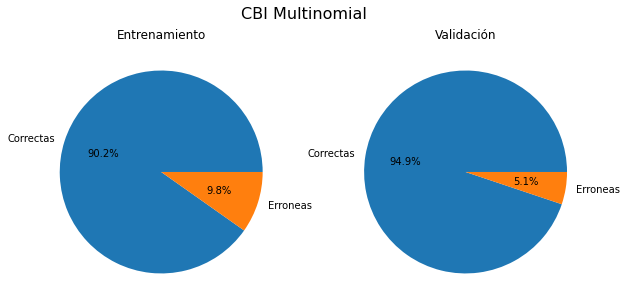

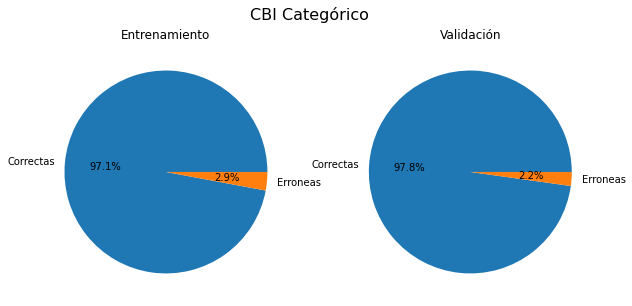

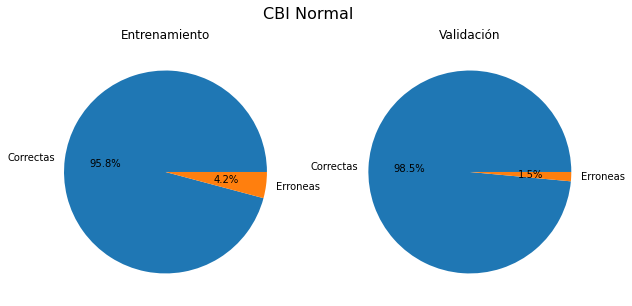

In [14]:
fig1, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
fig1.suptitle('CBI Multinomial', fontsize=16,y=0.83)
ax1.pie(mnlb_del.score(x_ent1,y_ent1),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax1.set_title('Entrenamiento')
ax2.pie(mnlb_del.score(x_val1,y_val1),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax2.set_title('Validación')

fig2, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
fig2.suptitle('CBI Categórico', fontsize=16,y=0.83)
ax1.pie(ctnb_del.score(x_ent1,y_ent1),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax1.set_title('Entrenamiento')
ax2.pie(ctnb_del.score(x_val1,y_val1),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax2.set_title('Validación')

#Calcular correctas y erroneas en el conjunto de entrenamiento
corr=sum(clf_del.predict(x_ent1)==y_ent1)
count_ent = [corr, len(y_ent1)-corr]

#Calcular correctas y erroneas en el conjunto de validación
corr=sum(clf_del.predict(x_val1)==y_val1)
count_val = [corr, len(y_val1)-corr]

fig3, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
fig3.suptitle('CBI Normal', fontsize=16,y=0.83)
ax1.pie(count_ent,labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax1.set_title('Entrenamiento')
ax2.pie(count_val,labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax2.set_title('Validación')

plt.show()

#### Remplazando los valores faltantes

Se pueden reemplazar los datos faltantes con valores arbitrarios, con el promedio, la media o la moda. También se utilizan otros métodos como interpolación.

En este casi reemplazaremos los valores con la moda y veremos si hay algún cambio significativo en las predicciones.


<AxesSubplot:>

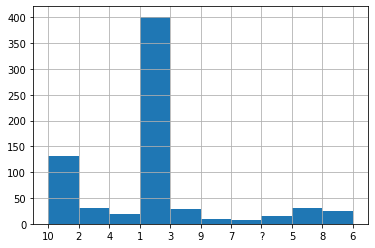

In [15]:
df["Núcleos desnudos"].hist()

In [16]:
df_mean = df.replace('?',1)
df_mean = df_mean.astype({"Núcleos desnudos": 'int64'})

Dividir aleatoramente el conjunto de datos con 60% de datos de entrenamiento, 20% de validación y 20% de prueba, usando 0 como semilla para el generador de números aleatorios.

In [17]:
data = df_mean.to_numpy()
x = data[:,1:-1]
y = data[:,-1]
x_ent2, x, y_ent2, y = train_test_split(x,y,train_size=0.60, random_state=0)
x_val2, x_pru2, y_val2, y_pru2 = train_test_split(x,y,train_size=0.50, random_state=0)

##### Entrenamiento con CBI Multinomial y Categórico

In [18]:
mnlb_mean = MultinomialNBLog_Bernoulli()
mnlb_mean.fit(x_ent2, y_ent2)

ctnb_mean = CategoricalNB()
ctnb_mean.fit(x_ent2, y_ent2)

clf_mean = GaussianNB()
clf_mean.fit(x_ent2, y_ent2)

GaussianNB()

##### Predicciones

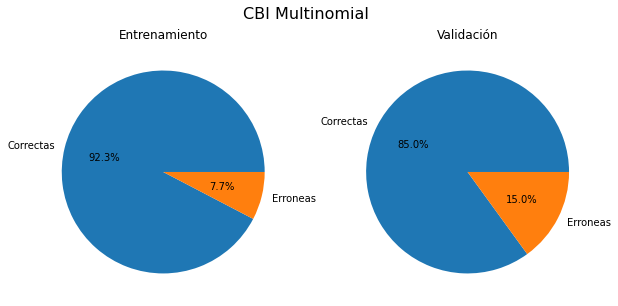

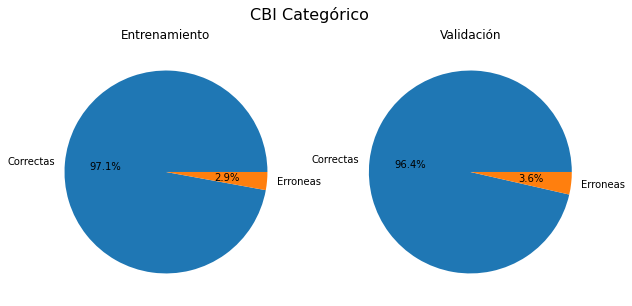

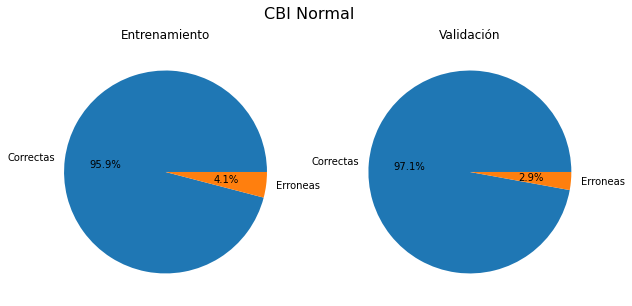

In [19]:
fig1, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
fig1.suptitle('CBI Multinomial', fontsize=16,y=0.83)
ax1.pie(mnlb_mean.score(x_ent2,y_ent2),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax1.set_title('Entrenamiento')
ax2.pie(mnlb_mean.score(x_val2,y_val2),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax2.set_title('Validación')

fig2, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
fig2.suptitle('CBI Categórico', fontsize=16,y=0.83)
ax1.pie(ctnb_mean.score(x_ent2,y_ent2),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax1.set_title('Entrenamiento')
ax2.pie(ctnb_mean.score(x_val2,y_val2),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax2.set_title('Validación')

#Calcular correctas y erroneas en el conjunto de entrenamiento
corr=sum(clf_mean.predict(x_ent2)==y_ent2)
count_ent = [corr, len(y_ent2)-corr]

#Calcular correctas y erroneas en el conjunto de validación
corr=sum(clf_mean.predict(x_val2)==y_val2)
count_val = [corr, len(y_val2)-corr]

fig3, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
fig3.suptitle('CBI Normal', fontsize=16,y=0.83)
ax1.pie(count_ent,labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax1.set_title('Entrenamiento')
ax2.pie(count_val,labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax2.set_title('Validación')

plt.show()

## Conjunto de datos con mejor rendimiento

El clasificador que más predicciones correctas tuvo en el conjunto de entrenamiento como en el de validación fue el categórico.

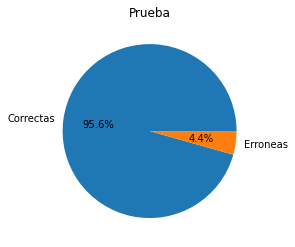

In [25]:
#Calcular correctas y erroneas en el conjunto de prueba
corr=sum(clf_mean.predict(x_pru1)==y_pru1)
count_pru = [corr, len(y_pru1)-corr]

plt.pie(count_pru,labels=['Correctas','Erroneas'], autopct='%1.1f%%')
plt.title('Prueba')
plt.show()

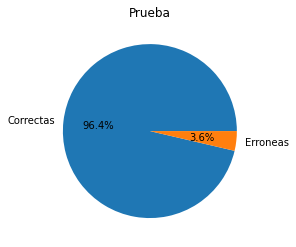

In [27]:
plt.pie(ctnb_del.score(x_pru1,y_pru1),labels=['Correctas','Erroneas'], autopct='%1.1f%%')
plt.title('Prueba')
plt.show()

## Observaciones y comentarios

Se utilizaron 3 tipos de distribuciones para los datos: multinomial, categórico y normal.

En las primeras dos se utilizó el logaritmo para calcular las probabilidades, pues se tiene un gran número de multiplicaciones. También se usó el estimador por maxima verosimilitud y para las clases siempre se utilizó una distribución de bernoulli. El clasificador que obtuvo mejores resultados en el conjunto de entrenamiento fue el categórico, por la naturaleza de los datos y como estos se almacenaron. Sin embargo, en el conjunto de validación, se tiene una mejor generalización con el clasificador con una distribución normal. Finalmente, en el conjunto de prueba el modelo categórico tiene menor porcentaje de predicciones erroneas que el modelo normal.

Se emplearon dos formas para tratar los datos faltantes: eliminar las filas que contenian atributos faltantes y reemplazar los valores faltantes con la moda. Con el primer método se obtuvo mejores resultados en ambos clasificadores, pues el porcentaje de datos faltantes es muy pequeño, alrededor del $2\%$.